Left over background might be contributing to the weird results, experiment with how the background is removed.

## Look into the surface brightness limit calculation 

In [4]:
from astropy.cosmology import FlatLambdaCDM
from astropy.io import ascii
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
import numpy as np
import h5py

cutouts = h5py.File('../cutouts.hdf')
zs = ascii.read('../../data/processed/camira_final.tbl')['z_cl']
cosmo = FlatLambdaCDM(H0=68.4, Om0=0.301)

In [7]:
# Convenience function for plotting the images
stddev = 0.017359
def stretch(img):
    return np.arcsinh(np.clip(img, a_min=0.0, a_max=10.0) / stddev)

In [2]:
from photutils.background import Background2D
from scipy.interpolate import CloughTocher2DInterpolator

def background_estimate(cutout, mask=None):
    """
    Returns an estimate of the 2D background of `cutout`. The background is 
    measured in boxes of size 50px around the edges of the image, and the
    background is interpolated over the entire image. 
    """
    # Run photutil's Background2D for the low resolution grid
    bkg_initial = Background2D(cutout, box_size=50, mask=mask)
    mesh = bkg_initial.background_mesh
    
    # Extract just the edges of the mesh
    size_x = mesh.shape[0]
    size_y = mesh.shape[1]
    xvals = np.arange(0, size_x)
    yvals = np.arange(0, size_y)

    box_size = 50
    box_cen = (box_size - 1) / 2.0

    top = np.column_stack((xvals, (size_y - 1) * np.ones(size_x, dtype=int)))
    bottom = np.column_stack((xvals, np.zeros(size_x, dtype=int)))
    left = np.column_stack((np.zeros(size_y, dtype=int), yvals))
    right = np.column_stack(((size_x - 1) * np.ones(size_y, dtype=int), yvals))

    # Indices of edges
    square = np.unique(np.concatenate((top, bottom, left, right), axis=0), axis=0)
    # Pixel locations of centres of edge boxes
    real_square = box_size * square + box_cen

    # Get the values from the mesh corresponding to the coordinates
    vals = np.array([mesh[tuple(c)] for c in square])

    # Interpolate between the edges of the square
    interp = CloughTocher2DInterpolator(real_square, vals)
    x = np.arange(np.min(real_square[:,0]), np.max(real_square[:,0]))
    y = np.arange(np.min(real_square[:,1]), np.max(real_square[:,1]))
    x, y = np.meshgrid(x, y) # 2D grid
    z = interp(x, y).T

    # Expand the image to the correct size
    edge_widths = (
        (int(np.abs(cutout.shape[0] - z.shape[0])/2), 
        int(np.ceil(np.abs(cutout.shape[0] - z.shape[0])/2))),
        (int(np.abs(cutout.shape[1] - z.shape[1])/2),
        int(np.ceil(np.abs(cutout.shape[1] - z.shape[1])/2)))
    )
    bkg = np.pad(z, pad_width=edge_widths, mode='reflect')

    # Return background estimation
    return bkg

def create_circular_mask(z, img, cosmo, radius_kpc=130):
    """
    Returns a circular mask of 130kpc radius for given `z` and given cosmology
    `cosmo` for image `img`.
    """
    # Calculate the radius in pixels
    arcsec_to_px = 1/0.168
    radius = (cosmo.arcsec_per_kpc_proper(z) * radius_kpc).value * arcsec_to_px
    
    # Generate the mask
    centre = (img.shape[1] // 2, img.shape[0] // 2)
    Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
    dist_from_centre = np.sqrt((X-centre[0])**2 + (Y-centre[1])**2)

    mask = dist_from_centre <= radius

    return mask

def counts2sb(counts, z):
    return 2.5 * np.log10(63095734448.0194 / counts) + 5 * np.log10(0.168) - 10 * np.log10(1+z)

def sb2counts(sb): # without reaccounting for dimming
    return 10**(-0.4*(sb - 2.5*np.log10(63095734448.0194) - 5.*np.log10(0.168)))

In [3]:
cutout_idx = 18

cutout = cutouts[str(cutout_idx)]
mask_data = np.array(cutout['HDU1']['DATA']).astype(int)
BAD = 1
BRIGHT_OBJECT = 512
bad_mask = (mask_data & (BAD | BRIGHT_OBJECT)).astype(bool)

# Create image, subtract background and create circular mask
img_data = np.array(cutout['HDU0']['DATA'])
bkg = background_estimate(img_data, mask=bad_mask)

circ_mask = create_circular_mask(zs[cutout_idx], img_data, cosmo)
img = img_data - bkg

# Convert image from counts to surface brightness, accounting for dimming
np.seterr(invalid='ignore', divide='ignore')
sb_img = counts2sb(img, zs[cutout_idx])

# From Cristina's code, who cites Roman+20 for this formula
_, _, stddev = sigma_clipped_stats(img_data, mask=bad_mask)
sb_lim = -2.5 * np.log10(3*stddev/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)


bkg_p = Background2D(img_data, (50,50))
mesh = bkg_p.background_rms_mesh

# Extract just the edges of the mesh
size_x = mesh.shape[0]
size_y = mesh.shape[1]
xvals = np.arange(0, size_x)
yvals = np.arange(0, size_y)

box_size = 50
box_cen = (box_size - 1) / 2.0

top = np.column_stack((xvals, (size_x - 1) * np.ones(size_x, dtype=int)))
bottom = np.column_stack((xvals, np.zeros(size_x, dtype=int)))
left = np.column_stack((np.zeros(size_y, dtype=int), yvals))
right = np.column_stack(((size_y - 1) * np.ones(size_y, dtype=int), yvals))

# Indices of edges
square = np.unique(np.concatenate((top, bottom, left, right), axis=0), axis=0)
vals = np.array([mesh[tuple(c)] for c in square])
print(np.median(vals))

print(bkg_p.background_rms_median)

sb_lim_old = -2.5 * np.log10(3*stddev/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)
sb_lim = -2.5 * np.log10(3*np.median(vals)/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)

print(stddev)
print(sb_lim_old)
print(sb_lim)
    

0.03725716828327752
0.03856488214503667
0.045555547
29.724116906086557
29.942445458941087


## Find the flux at different apertures from the centre of the BCG and find where the profile is flat

[0.41318722628511606, 0.3959005509393752, 0.3576387169295543, 0.21555736942897746, 0.15337950076502035, 0.11253279604010337, 0.08567403084650772, 0.06807545425652244, 0.05472560906285486, 0.045375644639142815, 0.0375924483837018, 0.03232956550784793, 0.02852759704999544, 0.02565457189910524, 0.023442365431546416, 0.021010333273691752, 0.01898687852577217, 0.017160185578226964, 0.015543456290039954, 0.014101838617439362, 0.013374473459871045, 0.012316405104925423, 0.011528115880095028, 0.010764974684902532, 0.010044195675279257, 0.00936031457699054, 0.00886092237604815, 0.008481375462177754, 0.00809664288693999, 0.007613255637307811, 0.007121913029216447, 0.006820333255744561, 0.006699481218466776, 0.006564931573437179, 0.0064022417798123, 0.006297230327016964, 0.006154409889428558, 0.005993159256864044, 0.005897932150854695]


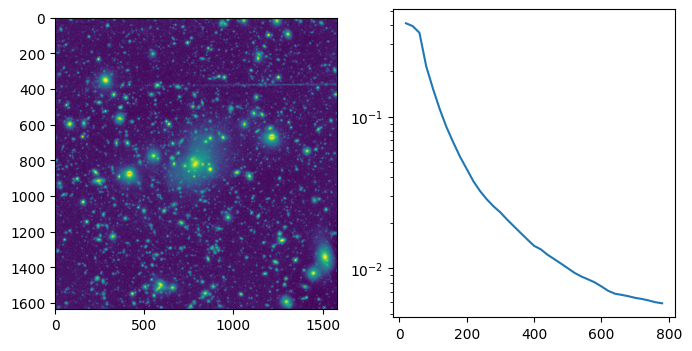

In [8]:
from photutils.aperture import CircularAnnulus
from astropy.stats import sigma_clipped_stats

cutout_idx = 60

# Load the 550kpc radius downloaded cutouts
cutouts = h5py.File('../cutouts_550.hdf')

cutout = cutouts[str(cutout_idx)]
img_data = np.array(cutouts[str(cutout_idx)]['HDU0']['DATA'])
mask_data = np.array(cutouts[str(cutout_idx)]['HDU1']['DATA']).astype(int)
bad_mask = (mask_data & (1 | 512)).astype(bool)

# Subtract the background from the image
bkg = background_estimate(img_data)
img = img_data - bkg

# Define thepertures
fluxes = []
centre = (img.shape[0] // 2, img.shape[1] // 2)
r_in = 0.1
r_out = 20

while r_out < np.min(centre):
    # Create the circular aperture
    aperture = CircularAnnulus(centre, r_in=r_in, r_out=r_out)
    mask = aperture.to_mask()

    # Get the image and mask data inside this annulus
    annulus = mask.cutout(img, fill_value=np.nan)
    mask_cutout = mask.cutout(bad_mask, fill_value=False)

    # Calculate the sigma clipped average of values in the annulus
    mean, median, _ = sigma_clipped_stats(annulus, mask=mask_cutout)
    fluxes.append(mean)

    # Update the radii
    r_in += 20
    r_out += 20

print(fluxes)
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(stretch(img))
plt.subplot(122)
plt.plot(np.arange(20, r_out, step=20), fluxes)
plt.yscale('log')
plt.show()

0.0034277212259087963


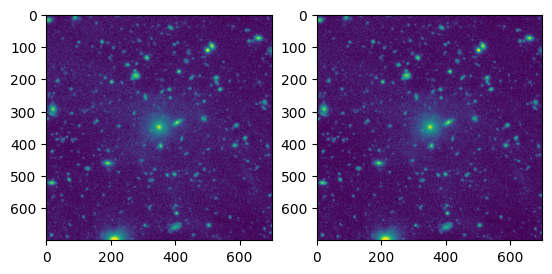

In [9]:
# Take the median of values in the part of the profile >350kpc away and subtract from the image
cutout_idx = 118
px_threshold = (cosmo.arcsec_per_kpc_proper(zs[cutout_idx]) * 350).value * 1/0.168

cutout = cutouts[str(cutout_idx)]
img_data = np.array(cutouts[str(cutout_idx)]['HDU0']['DATA'])
mask_data = np.array(cutouts[str(cutout_idx)]['HDU1']['DATA']).astype(int)
bad_mask = (mask_data & (1 | 512)).astype(bool)

# Subtract the background from the image
bkg = background_estimate(img_data)
img = img_data - bkg

# Define the apertures
fluxes = []
centre = (img.shape[0] // 2, img.shape[1] // 2)
r_in = px_threshold
r_out = px_threshold + 20

while r_out < np.min(centre):
    # Create the circular aperture
    aperture = CircularAnnulus(centre, r_in=r_in, r_out=r_out)
    mask = aperture.to_mask()

    # Get the image and mask data inside this annulus
    annulus = mask.cutout(img, fill_value=np.nan)
    mask_cutout = mask.cutout(bad_mask, fill_value=False)

    # Calculate the sigma clipped average of values in the annulus
    mean, median, _ = sigma_clipped_stats(annulus, mask=mask_cutout)
    fluxes.append(mean)

    # Update the radii
    r_in += 20
    r_out += 20

sky_value = np.nanmedian(fluxes)
print(sky_value)

row_cen = img.shape[0] // 2
col_cen = img.shape[1] // 2

plt.subplot(121)
plt.imshow(stretch(img[row_cen-350:row_cen+350, col_cen-350:col_cen+350]))
plt.subplot(122)
plt.imshow(stretch(img[row_cen-350:row_cen+350, col_cen-350:col_cen+350] - sky_value))
plt.show()

## Updating background estimate function to work better with larger cutouts

In [10]:
def background_estimate(cutout, mask=None, z=None, cosmo=None):
    """
    Returns an estimate of the 2D background of `cutout`. The background is 
    measured in boxes of size 50px around the edges of the image, and the
    background is interpolated over the entire image. 
    """
    box_size = cutout.shape[0] // 14
    
    # Run photutil's Background2D for the low resolution grid
    bkg_initial = Background2D(cutout, box_size=box_size, mask=mask)
    mesh = bkg_initial.background_mesh

    # Extract the edges of the mesh
    Y, X = np.ogrid[:mesh.shape[0], :mesh.shape[1]]
    y_cen, x_cen = (mesh.shape[0] // 2, mesh.shape[1] // 2) 

    box_cen = (box_size - 1) / 2.0

    if cosmo is not None:
        # Create a mask to cover the internal 350 kpc
        px_dist = cosmo.arcsec_per_kpc_proper(z) * 350 * 1/0.168
        size = int(np.ceil(px_dist.value / box_size))
        box = (X > x_cen - size) & (X < x_cen + size) & (Y > y_cen - size) & (Y < y_cen + size)
    else:
        # Get values from the edges of the cutout (basically for backwards compatibility with the old version)
        box = ~((X == 0) | (X == X.shape[1] - 1) | (Y == 0) | (Y == Y.shape[0] - 1))

    # Get values from the mesh corresponding to these coordinates
    vals = mesh[~box]

    # Array of coordinates in image units
    real_square = np.argwhere(~box) * box_size + box_cen

    # Interpolate over the centre of the square
    interp = CloughTocher2DInterpolator(real_square, vals)
    x = np.arange(np.min(real_square[:,0]), np.max(real_square[:,0]))
    y = np.arange(np.min(real_square[:,1]), np.max(real_square[:,1]))
    x, y = np.meshgrid(x, y) # 2D grid
    z = interp(x, y).T

    # Expand the image to the correct size
    edge_widths = (
        (int(np.abs(cutout.shape[0] - z.shape[0])/2), 
        int(np.ceil(np.abs(cutout.shape[0] - z.shape[0])/2))),
        (int(np.abs(cutout.shape[1] - z.shape[1])/2),
        int(np.ceil(np.abs(cutout.shape[1] - z.shape[1])/2)))
    )
    bkg = np.pad(z, pad_width=edge_widths, mode='reflect')

    # Return background estimation
    return bkg

In [11]:
# Define a new measure_icl_test to use the new changes
# Messing with the original function to try and make it work better for my data
from matplotlib import cm

def measure_icl_test(cutout_idx, plot=True):
    cutout = cutouts[str(cutout_idx)]
    mask_data = np.array(cutout['HDU1']['DATA']).astype(int)
    z = zs[cutout_idx]
    BAD = 1
    BRIGHT_OBJECT = 512
    bad_mask = (mask_data & (BAD | BRIGHT_OBJECT)).astype(bool)
    
    # Create image, subtract background and create circular mask
    img_data = np.array(cutout['HDU0']['DATA'])
    bkg = background_estimate(img_data, mask=bad_mask, z=z, cosmo=cosmo)

    circ_mask = create_circular_mask(zs[cutout_idx], img_data, cosmo, radius_kpc=200)
    img = img_data - bkg

    # Surface brightness limit calculation
    _, _, stddev = sigma_clipped_stats(img, mask=bad_mask)
 
    # From Cristina's code, who cites Roman+20 for this formula
    sb_lim = -2.5 * np.log10(3*stddev/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)

    # Convert image from counts to surface brightness, accounting for dimming
    np.seterr(invalid='ignore', divide='ignore')
    # sb_img = counts2sb(img, zs[cutout_idx])
    sb_img = counts2sb(img, 0)
    
    # Mask out the values below surface brightness limit
    sb_img[sb_img >= sb_lim] = np.nan
    
    # Calculate SB threshold, accounting for dimming
    threshold = 25 + 10 * np.log10(1 + zs[cutout_idx])
    mask = sb_img > threshold

    # Convert the SB image back to counts
    counts_img = sb2counts(sb_img)

    # Apply circular mask
    counts_img = counts_img * circ_mask

    cmap = cm.viridis
    cmap.set_bad(cmap(0))
    if plot:
        plt.figure(figsize=(8,4), dpi=200)
        plt.subplot(121)
        plt.imshow(stretch(counts_img) * mask * ~bad_mask, cmap=cmap, vmin=0, vmax=stretch(sb2counts(25)), interpolation='none')
        plt.subplot(122)
        plt.imshow(stretch(counts_img) * ~bad_mask, cmap=cmap, interpolation='none')
        plt.show()

    masked_img = counts_img * ~bad_mask
    print(np.sum((masked_img * mask)[~np.isnan(counts_img)]) / np.sum((masked_img)[~np.isnan(counts_img)]))

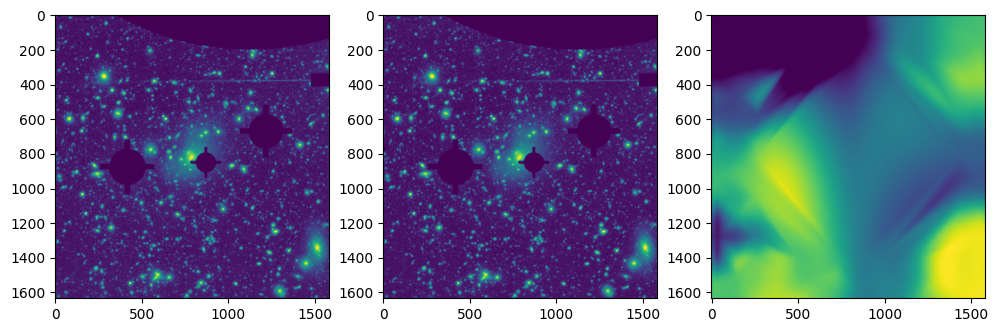

In [13]:
cutouts = h5py.File('../cutouts_550.hdf')

idx = 60
cutout = cutouts[str(idx)]['HDU0']['DATA']
mask = (np.array(cutouts[str(idx)]['HDU1']['DATA']).astype(int) & (1 | 512)).astype(bool)
cosmo = FlatLambdaCDM(H0=68.4, Om0=0.301)
bkg = background_estimate(cutout, mask, zs[idx], cosmo)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(stretch(cutout) * ~mask)
plt.subplot(132)
plt.imshow(stretch(cutout - bkg) * ~mask)
plt.subplot(133)
plt.imshow(stretch(bkg))
plt.show()

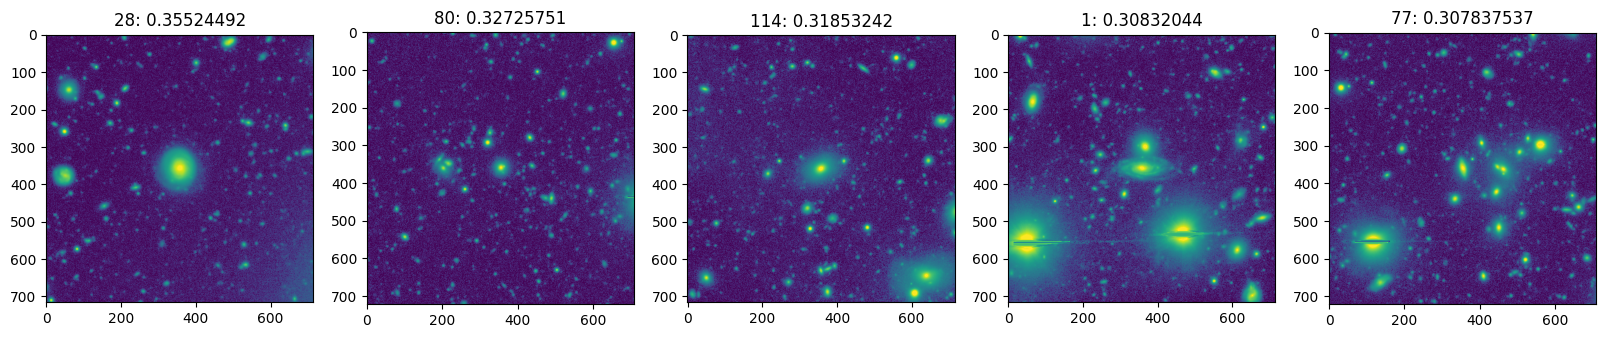

In [15]:
# Calculated elsewhere with the new background_estimate method
top_5 = [ 28, 80, 114, 1, 77]
top_5_fracs = [0.35524492, 0.32725751, 0.31853242, 0.30832044, 0.307837537]
bottom_5 = [ 9, 86, 59, 20, 33]
bottom_5_fracs = [0.04752481, 0.05330894, 0.06502792, 0.06870566, 0.07145573]

cutouts = h5py.File('../cutouts.hdf')

plt.figure(figsize=(20,4))
for i, idx in enumerate(top_5):
    plt.subplot(1, 5, i+1)
    plt.imshow(stretch(cutouts[str(idx)]['HDU0']['DATA']))
    plt.title(f'{idx}: {top_5_fracs[i]}')
plt.show()

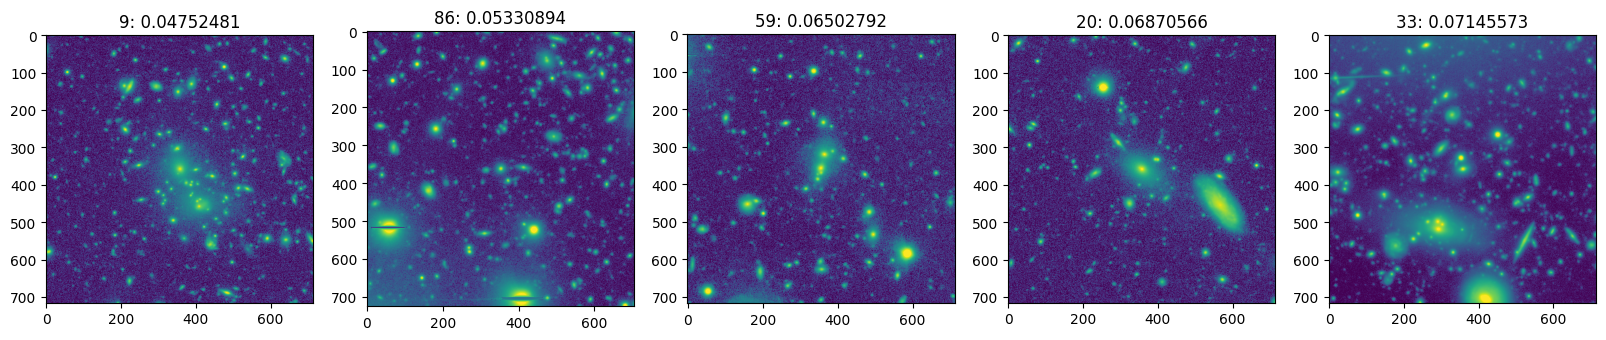

In [16]:
plt.figure(figsize=(20,4))
for i, idx in enumerate(bottom_5):
    plt.subplot(1, 5, i+1)
    plt.imshow(stretch(cutouts[str(idx)]['HDU0']['DATA']))
    plt.title(f'{idx}: {bottom_5_fracs[i]}')
plt.show()

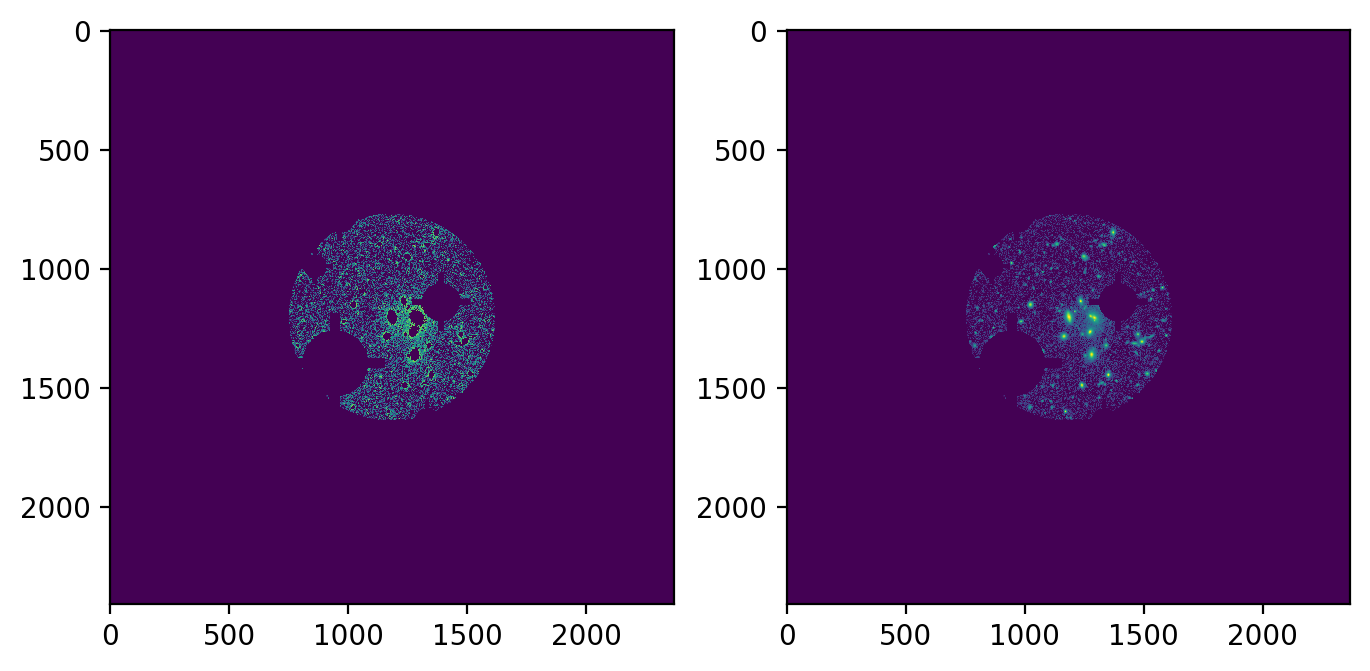

0.3076570336614056


In [20]:
cutouts = h5py.File('../cutouts_550.hdf')
measure_icl_test(77)

[0.2611076228724262, 0.07960082391929155, 0.04385958821728042, 0.02946288308803731, 0.021303088327219773, 0.01652175084797347, 0.013514387730583078, 0.011759833914110264, 0.009900774717663322, 0.008174578696400675, 0.006698496764481954, 0.005595829082459612, 0.004672512581305303, 0.0040026131243088535, 0.0034477921148039375, 0.003201722698253715, 0.0029959654054492807, 0.002808822203841103, 0.0027628143539803144, 0.0028391897296076198, 0.0028658378648604463, 0.002890591015937404, 0.0028626755639022884, 0.002759701371805461, 0.002593483653629261, 0.002564106609376167, 0.0025817629248202113, 0.0025477126322069987, 0.0024782052310546926, 0.0023800204754104944]


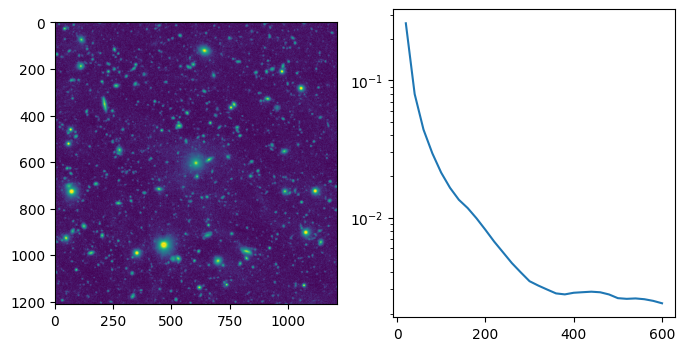

In [21]:
# Check the radial profile stuff with the new background estimate function
from photutils.aperture import CircularAnnulus
from astropy.stats import sigma_clipped_stats

cutout_idx = 118

# Load the 550kpc radius downloaded cutouts
cutouts = h5py.File('../cutouts_550.hdf')

cutout = cutouts[str(cutout_idx)]
img_data = np.array(cutouts[str(cutout_idx)]['HDU0']['DATA'])
mask_data = np.array(cutouts[str(cutout_idx)]['HDU1']['DATA']).astype(int)
bad_mask = (mask_data & (1 | 512)).astype(bool)

# Subtract the background from the image
bkg = background_estimate(img_data, mask=bad_mask, z=zs[cutout_idx], cosmo=cosmo)
img = img_data - bkg

# Define thepertures
fluxes = []
centre = (img.shape[0] // 2, img.shape[1] // 2)
r_in = 0.1
r_out = 20

while r_out < np.min(centre):
    # Create the circular aperture
    aperture = CircularAnnulus(centre, r_in=r_in, r_out=r_out)
    mask = aperture.to_mask()

    # Get the image and mask data inside this annulus
    annulus = mask.cutout(img, fill_value=np.nan)
    mask_cutout = mask.cutout(bad_mask, fill_value=False)

    # Calculate the sigma clipped average of values in the annulus
    mean, median, _ = sigma_clipped_stats(annulus, mask=mask_cutout)
    fluxes.append(mean)

    # Update the radii
    r_in += 20
    r_out += 20

print(fluxes)
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(stretch(img))
plt.subplot(122)
plt.plot(np.arange(20, r_out, step=20), fluxes)
plt.yscale('log')
plt.show()

Secondary background subtraction doesn't seem to fix any issues with the icl measurement, so not using it for now.

## Exclusions based on amount of background subtracted?

In [ ]:
# For which clusters is the bkg subtracted larger than the total light left in the circle?
fracs = np.load('../../fracs.npy')

for key in cutouts.keys():
    cutout = cutouts[key]['HDU0']['DATA']
    mask = np.array(cutouts[key]['HDU1']['DATA']).astype(int)
    bad_mask = (mask & (1 | 512)).astype(bool)

    # Create the circular mask
    circ_mask = create_circular_mask(zs[key], cutout, cosmo)

    # Check if this cutout should be excluded because too much is masked
    inner_frac_masked = np.sum(bad_mask * circ_mask) / np.sum(circ_mask)
    mid = (bad_mask.shape[0] // 2, bad_mask.shape[1] // 2)

    if inner_frac_masked > 0.2 or bad_mask[mid]:
        # >20% of inner region masked or middle pixel is masked
        continue

    bkg = background_estimate(cutout, bad_mask, zs[int(key)], cosmo)
    bkg_subtracted = np.sum(bkg)
    if bkg_subtracted > fracs[1, int(key)]:
        print(key)

10
106
107


ValueError: All boxes contain > 1123.6000000000001 (10.0 percent per box) masked pixels (or all are completely masked). Please check your data or increase "exclude_percentile" to allow more boxes to be included.